In [1]:
import os
import redshift_utils as rs
import pandas as pd
import time
import sagemaker
import boto3
import io
from io import StringIO
from skrub import TableReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skrub import TableReport

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
bucket = "edcs3.prod.biads"
boto_session = boto3.session.Session(region_name="eu-west-1")
sess = sagemaker.session.Session(boto_session, default_bucket=bucket)
region = sess.boto_session.region_name
account = sess.boto_session.client('sts').get_caller_identity()['Account']
role = sagemaker.get_execution_role()
ssm_client = boto3.client('ssm')
kms_key = ssm_client.get_parameter(Name='/prod/sagemaker/BIADS/sloth/KMS_KEY_ID', WithDecryption=True)["Parameter"]["Value"] 

def load_data(params, sql):
    sloth_credentials = rs.get_sloth_credentials()
    con = rs.connect_to_redshift(sloth_credentials)
    data = rs.execute_sql(
        RSconn=con,
        sql=sql,
        input_type="file",
        params=params
    )
    return data

## 2023/2024


In [8]:
# Create prep table
params = {'@iam': 'arn:aws:iam::765819017647:role/rs-edcs3.prod.marketing',
          '@kms': kms_key, 
         }
data = load_data(params=params, sql='../data/sandbox.sql')
pd.set_option('display.max_columns', None)  # Show all columns
df = pd.DataFrame(data)
df.head(50)

,vol,rev,margin
0,9851790.7843,889417.7727,0.0902


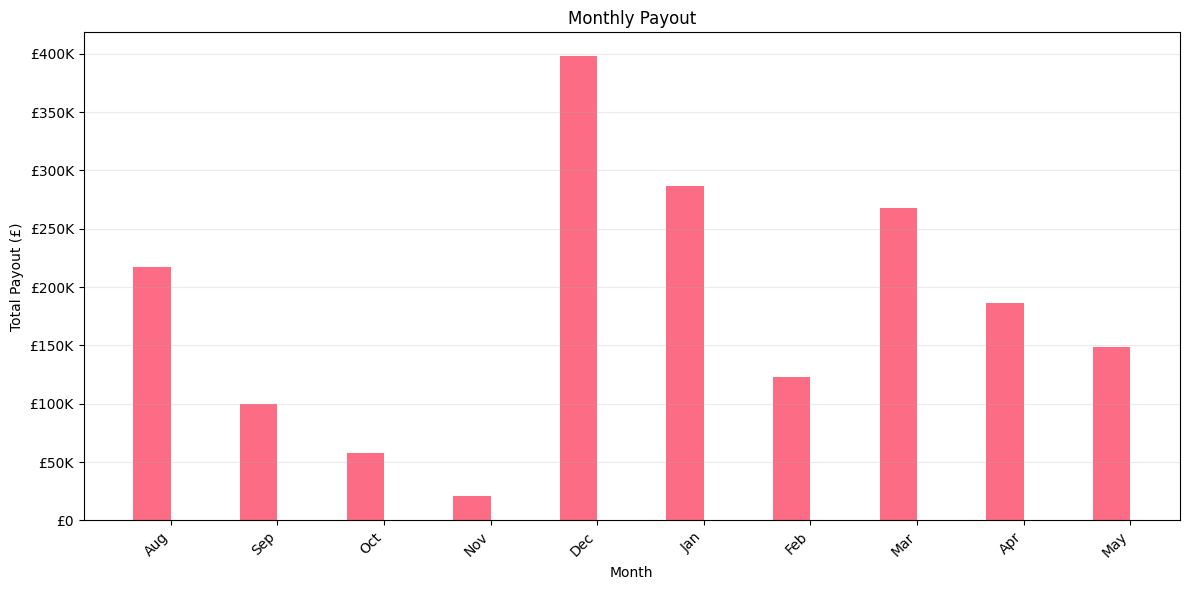

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import base64
from datetime import timedelta

df['event_scheduled_start_datetime'] = pd.to_datetime(df['event_scheduled_start_datetime'])

def get_month_start(dt):
    # Set the day to 1 for the start of the month
    # and reset time components to 0 to represent the very beginning of the day.
    return dt.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

df['week_start_thursday'] = df['event_scheduled_start_datetime'].apply(get_month_start)

# --- Aggregate Data ---
# Group by the custom week start and sum 'pay', count 'mult_id'
grouped_data = df.groupby('week_start_thursday').agg(
    total_payout=('potential_payout', 'sum')
).reset_index()

# Sort by week start date to ensure correct order in plot
grouped_data = grouped_data.sort_values(by='week_start_thursday')

# --- FORMATTING ---
# Currency formatter for the y-axis
def currency_formatter_bmt(x, pos):
    if x >= 1_000_000_000:
        return f'£{x*1e-9:1.1f}B'
    if x >= 1_000_000:
        return f'£{x*1e-6:1.1f}M'
    if x >= 1_000:
        return f'£{x*1e-3:1.0f}K'
    return f'£{x:1.0f}'

# --- Visualization ---
# Colors
pay_color = '#FC6C85' # Light green

fig, ax1 = plt.subplots(figsize=(12, 6)) # Create figure and first axis

# Bar width and positions
bar_width = 0.35
indices = range(len(grouped_data))

# Plot 'total_pay' on primary y-axis
rects1 = ax1.bar([i - bar_width/2 for i in indices], grouped_data['total_payout'], bar_width, label='Total Payout', color=pay_color)
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Payout (£)')
ax1.tick_params(axis='y')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter_bmt))

# Set x-axis ticks and labels
ax1.set_xticks(indices)
ax1.set_xticklabels(grouped_data['week_start_thursday'].dt.strftime('%b'), rotation=45, ha='right')

# Title and Layout
plt.title('Monthly Payout')
fig.tight_layout() # Adjust layout to prevent labels overlapping

# Add grid lines for better readability
ax1.grid(axis='y', linestyle='-', alpha=0.25)


# Combine legends
lines, labels = ax1.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot (for local execution)
plt.show()

In [57]:
df['total_payout'].sum()
# df.shape


Decimal('1805460.929326')

## 2024/25 Simulation

In [6]:
# Create prep table
params = {'@iam': 'arn:aws:iam::765819017647:role/rs-edcs3.prod.marketing',
          '@kms': kms_key, 
         }
data = load_data(params=params, sql='../data/post2.sql')
pd.set_option('display.max_columns', None)  # Show all columns
df = pd.DataFrame(data)
df.tail(50)
df_sorted = df.sort_values(by='total_bets_laid_on_next_sot_level', ascending=False)
df_no_duplicates = df_sorted.drop_duplicates(
    subset=['total_bets_laid_on_next_sot_level'],
    keep='first'
)
print(df_no_duplicates)

df_no_duplicates = df_no_duplicates.reset_index(drop=True)

       event_id  market_id  selection_id    home_team    away_team  \
7240   13166264  471703645    2275960602    Liverpool      Man Utd   
7234   13166264  471703648    2275960739    Liverpool      Man Utd   
3131   12804248  460134403    2226823556      Arsenal    Liverpool   
1383   12609339  443478702    2155874595    Tottenham      Arsenal   
11360  13534459  494903391    2369643932      Man Utd     Man City   
...         ...        ...           ...          ...          ...   
12896  13736273  503134721    2405254542      Man Utd     West Ham   
62     12309918  439685151    1961859149     West Ham  Aston Villa   
28     12309863  439783218    1962285018    Newcastle  Southampton   
9211   13303997  479435052    2308921748  Aston Villa      Ipswich   
6788   13149200  471004593    2273014038    Brentford      Arsenal   

         selection_name  sot_level  actual_sot  \
7240      Mohamed Salah          2           1   
7234          Luis Diaz          1           0   
3131     

In [76]:
TableReport(df_no_duplicates)
# Check does reaggregation lead to total

Processing column  10 / 10


,,,,,,,,,,


In [46]:
# OPTA expectancy 23/24
198/ 3765

0.05258964143426295

In [17]:
# df_clean = df_no_duplicates.dropna()

# num_samples = 225 
# num_quantiles = 10  
# num_dfs_to_return = 2000 
# initial_random_state = 42 

# list_of_sampled_dfs = []

# for i in range(num_dfs_to_return):
#     current_random_state = initial_random_state + i
#     print(f"sample {i+1}/{num_dfs_to_return} rs ={current_random_state}...")

#     df_temp = df_clean.copy()

#     # quantile bins
#     df_temp['weight_quantile_bin'] = pd.qcut(
#         df_temp['total_bets_laid_on_next_sot_level'],
#         q=num_quantiles,
#         labels=False,
#         duplicates='drop'
#     )
#     df_temp['sim'] = i


#     total_rows = len(df_temp)
#     sampled_dfs_for_current_iteration = []
#     current_num_samples_in_iteration = 0

#     # Go throu each bin and sample
#     for bin_label in sorted(df_temp['weight_quantile_bin'].unique()):
#         bin_df = df_temp[df_temp['weight_quantile_bin'] == bin_label]
#         num_rows_in_bin = len(bin_df)

#         # how many bins
#         if current_num_samples_in_iteration < num_samples:
#             proportion_of_total = num_rows_in_bin / total_rows
#             num_to_sample_from_bin = min(num_rows_in_bin, round(num_samples * proportion_of_total))

#             num_to_sample_from_bin = min(num_to_sample_from_bin, num_samples - current_num_samples_in_iteration)

#             if num_to_sample_from_bin > 0:
#                 sampled_bin = bin_df.sample(
#                     n=int(num_to_sample_from_bin),
#                     replace=False,
#                     random_state=current_random_state + bin_label # Vary seed for each bin
#                 )
#                 sampled_dfs_for_current_iteration.append(sampled_bin)
#                 current_num_samples_in_iteration += len(sampled_bin)

#     list_of_sampled_dfs.append(current_final_sampled_df)

sample 1/2000 rs =42...
sample 2/2000 rs =43...
sample 3/2000 rs =44...
sample 4/2000 rs =45...
sample 5/2000 rs =46...
sample 6/2000 rs =47...
sample 7/2000 rs =48...
sample 8/2000 rs =49...
sample 9/2000 rs =50...
sample 10/2000 rs =51...
sample 11/2000 rs =52...
sample 12/2000 rs =53...
sample 13/2000 rs =54...
sample 14/2000 rs =55...
sample 15/2000 rs =56...
sample 16/2000 rs =57...
sample 17/2000 rs =58...
sample 18/2000 rs =59...
sample 19/2000 rs =60...
sample 20/2000 rs =61...
sample 21/2000 rs =62...
sample 22/2000 rs =63...
sample 23/2000 rs =64...
sample 24/2000 rs =65...
sample 25/2000 rs =66...
sample 26/2000 rs =67...
sample 27/2000 rs =68...
sample 28/2000 rs =69...
sample 29/2000 rs =70...
sample 30/2000 rs =71...
sample 31/2000 rs =72...
sample 32/2000 rs =73...
sample 33/2000 rs =74...
sample 34/2000 rs =75...
sample 35/2000 rs =76...
sample 36/2000 rs =77...
sample 37/2000 rs =78...
sample 38/2000 rs =79...
sample 39/2000 rs =80...
sample 40/2000 rs =81...
sample 41

In [7]:
from scipy.stats import lognorm
import numpy as np

# Ensure only positive values
values = df_no_duplicates['total_bets_laid_on_next_sot_level']
values = values[values > 0]

# Fit log-normal
shape, loc, scale = lognorm.fit(values, floc=0)


In [8]:
# Calculate probability density under the fitted distribution
pdf_vals = lognorm.pdf(df_no_duplicates['total_bets_laid_on_next_sot_level'], shape, loc=loc, scale=scale)

# Normalize to sum to 1 for sampling
df_no_duplicates['sampling_weight'] = pdf_vals / pdf_vals.sum()


In [9]:
num_dfs_to_return = 5000
initial_random_state = 42
rng = np.random.default_rng(initial_random_state)


list_of_sampled_dfs = []

for i in range(num_dfs_to_return):
    current_random_state = initial_random_state + i
    print(f"sample {i+1}/{num_dfs_to_return} rs={current_random_state}...")

    # Vary sample size between 200 and 300
    num_samples = rng.integers(low=200, high=301)
    sampled_df = df_no_duplicates.sample(
        n=num_samples,
        weights='sampling_weight',
        replace=True,  # or True depending on desired logic
        random_state=current_random_state
    )

    sampled_df = sampled_df.copy()
    sampled_df = sampled_df.drop(columns=['sampling_weight'])
    sampled_df = sampled_df.reset_index(drop=True)
    sampled_df['sim'] = i

    list_of_sampled_dfs.append(sampled_df)


sample 1/5000 rs=42...
sample 2/5000 rs=43...
sample 3/5000 rs=44...
sample 4/5000 rs=45...
sample 5/5000 rs=46...
sample 6/5000 rs=47...
sample 7/5000 rs=48...
sample 8/5000 rs=49...
sample 9/5000 rs=50...
sample 10/5000 rs=51...
sample 11/5000 rs=52...
sample 12/5000 rs=53...
sample 13/5000 rs=54...
sample 14/5000 rs=55...
sample 15/5000 rs=56...
sample 16/5000 rs=57...
sample 17/5000 rs=58...
sample 18/5000 rs=59...
sample 19/5000 rs=60...
sample 20/5000 rs=61...
sample 21/5000 rs=62...
sample 22/5000 rs=63...
sample 23/5000 rs=64...
sample 24/5000 rs=65...
sample 25/5000 rs=66...
sample 26/5000 rs=67...
sample 27/5000 rs=68...
sample 28/5000 rs=69...
sample 29/5000 rs=70...
sample 30/5000 rs=71...
sample 31/5000 rs=72...
sample 32/5000 rs=73...
sample 33/5000 rs=74...
sample 34/5000 rs=75...
sample 35/5000 rs=76...
sample 36/5000 rs=77...
sample 37/5000 rs=78...
sample 38/5000 rs=79...
sample 39/5000 rs=80...
sample 40/5000 rs=81...
sample 41/5000 rs=82...
sample 42/5000 rs=83...
s

In [10]:
concatenated_df = pd.concat(list_of_sampled_dfs, ignore_index=True)

output_directory = "concatenated_df_output" # A new directory for the single file
os.makedirs(output_directory, exist_ok=True)

# Define the file name for the single concatenated DataFrame
single_file_name = "all_sampled_data.parquet"
single_file_path = os.path.join(output_directory, single_file_name)

# Save the single concatenated DataFrame as a Parquet file
concatenated_df.to_parquet(single_file_path, index=False) # index=False prevents writing the DataFrame index as a column

print(f"Concatenated {len(list_of_sampled_dfs)} DataFrames into a single DataFrame.")
print(f"Saved the concatenated DataFrame to '{single_file_path}'.")

Concatenated 5000 DataFrames into a single DataFrame.
Saved the concatenated DataFrame to 'concatenated_df_output/all_sampled_data.parquet'.


In [91]:
print(list_of_sampled_dfs[0].head())

   event_id  market_id  selection_id     home_team    away_team  \
0  13076315  469083016    2264344316  Nottm Forest  Aston Villa   
1  12309918  439685151    1961859158      West Ham  Aston Villa   
2  13149202  470836764    2272278286   Aston Villa     Brighton   
3  12309924  439783269    1962286032  Nottm Forest  Bournemouth   
4  12899936  462698848    2237729962     Liverpool  Aston Villa   

    selection_name  sot_level  actual_sot  total_bets_laid_on_next_sot_level  \
0  Youri Tielemans          1           0                                794   
1  Guido Rodriguez          1           0                                 72   
2     Brajan Gruda          1           0                                275   
3  Justin Kluivert          1           0                                423   
4  Virgil van Dijk          1           0                               1653   

   next_sot_level_laid  sim  
0                    1    0  
1                    1    0  
2                    1    

In [3]:
# return results
# Create prep table
params = {'@iam': 'arn:aws:iam::765819017647:role/rs-edcs3.prod.marketing',
          '@kms': kms_key, 
         }
data = load_data(params=params, sql='../data/post.sql')
pd.set_option('display.max_columns', None)  # Show all columns
sim_df = pd.DataFrame(data)
sim_df.tail(50)

,sim,count
4950,4751,15576
4951,2602,51685
4952,4980,18623
4953,2284,39210
4954,2688,39928
4955,3004,18730
4956,3989,14870
4957,3780,49787
4958,1951,29817
4959,3067,27647


max 4652724.31442
Most likely payout (KDE mode): 1644896.06

Most Probable Total Payout: £1.6M
95% Confidence Interval: [£1.1M, £3.2M]


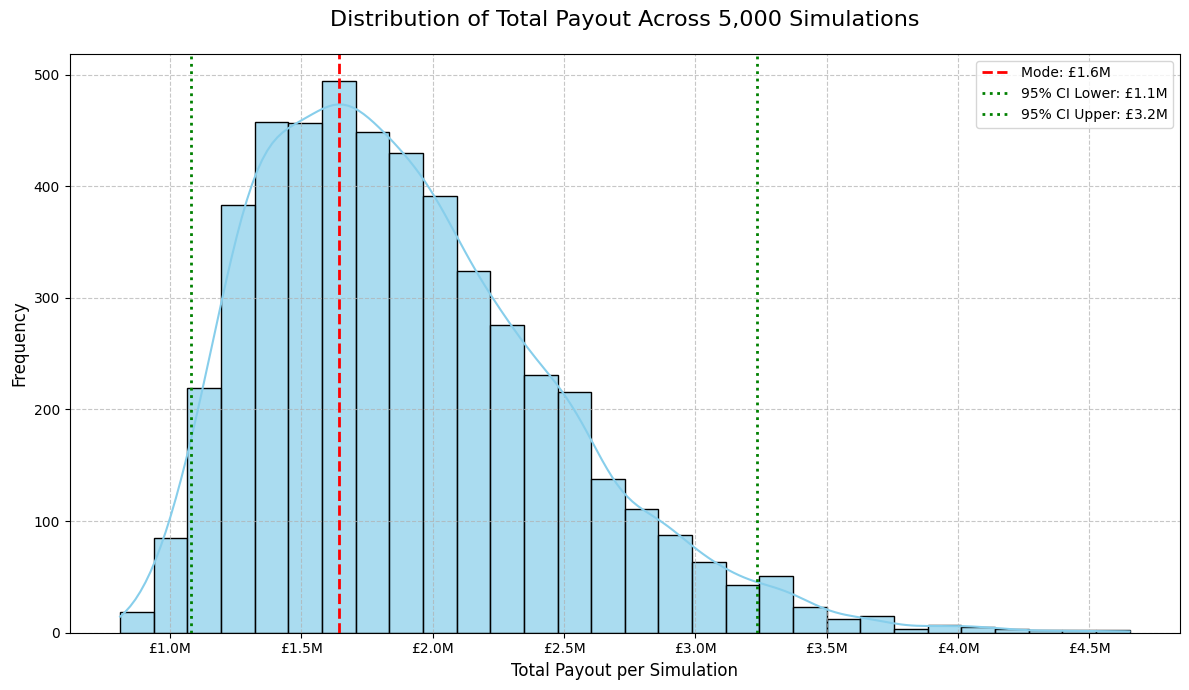

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import os
import matplotlib.ticker as mtick 

# Define the custom currency formatter function
def currency_formatter_bmt(x, pos):
    """
    Formats a number as currency with B, M, K suffixes for billions, millions, thousands.
    """
    if x >= 1_000_000_000:
        return f'£{x*1e-9:1.1f}B'
    if x >= 1_000_000:
        return f'£{x*1e-6:1.1f}M'
    if x >= 1_000:
        return f'£{x*1e-3:1.0f}K'
    return f'£{x:1.0f}'


# 1. Sum 'total_payout' grouped by 'sim'
total_payout_per_sim = sim_df.groupby('sim')['total_payout'].sum().reset_index()
total_payout_per_sim.rename(columns={'total_payout': 'sum_total_payout'}, inplace=True)

total_payout_per_sim['sum_total_payout'] = total_payout_per_sim['sum_total_payout'].astype(float)
max_val = total_payout_per_sim['sum_total_payout'].max()
print('max', max_val)
# MLE & 95% Confidence Intervals
values = total_payout_per_sim['sum_total_payout'].values

# KDE smoothing
kde = gaussian_kde(values)
x_grid = np.linspace(values.min(), values.max(), 1000)
pdf = kde(x_grid)
mode_kde = x_grid[np.argmax(pdf)]
# Mode = value where KDE (PDF) is highest
mode_payout = x_grid[np.argmax(pdf)]
print(f"Most likely payout (KDE mode): {mode_kde:.2f}")
lower_ci = total_payout_per_sim['sum_total_payout'].quantile(0.025)
upper_ci = total_payout_per_sim['sum_total_payout'].quantile(0.975)

print(f"\nMost Probable Total Payout: {currency_formatter_bmt(mode_payout, None)}")
print(f"95% Confidence Interval: [{currency_formatter_bmt(lower_ci, None)}, {currency_formatter_bmt(upper_ci, None)}]")


# 2. Plot the distribution of the sum of 'total_payout'
plt.figure(figsize=(12, 7)) # Slightly larger figure for better aesthetics
sns.histplot(total_payout_per_sim['sum_total_payout'], kde=True, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add vertical lines for Mean and 95% CI
plt.axvline(mode_payout, color='red', linestyle='--', linewidth=2, label=f'Mode: {currency_formatter_bmt(mode_payout, None)}')
plt.axvline(lower_ci, color='green', linestyle=':', linewidth=2, label=f'95% CI Lower: {currency_formatter_bmt(lower_ci, None)}')
plt.axvline(upper_ci, color='green', linestyle=':', linewidth=2, label=f'95% CI Upper: {currency_formatter_bmt(upper_ci, None)}')

plt.title('Distribution of Total Payout Across 5,000 Simulations', fontsize=16, pad=20)
plt.xlabel('Total Payout per Simulation', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend() # Show the labels for the vertical lines
plt.tight_layout()

# Apply the custom currency formatter to the x-axis
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(currency_formatter_bmt))

# Define the output path for the plot
plot_filename = 'total_payout_distribution_woodwork.png' 
plt.show()
plt.savefig(plot_filename)
plt.close() 



max 555894.589826
Most likely payout (KDE mode): 310834.26

Most Probable Total Payout: £311K
95% Confidence Interval: [£212K, £436K]


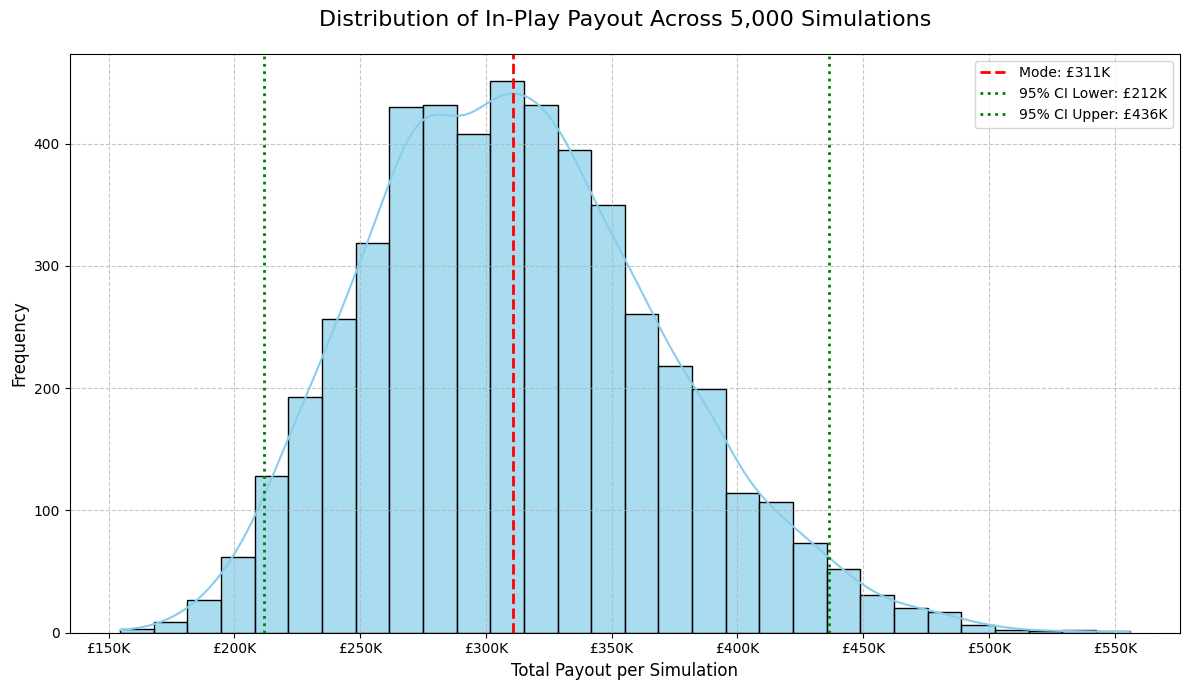

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import os
import matplotlib.ticker as mtick 

# Define the custom currency formatter function
def currency_formatter_bmt(x, pos):
    """
    Formats a number as currency with B, M, K suffixes for billions, millions, thousands.
    """
    if x >= 1_000_000_000:
        return f'£{x*1e-9:1.1f}B'
    if x >= 1_000_000:
        return f'£{x*1e-6:1.1f}M'
    if x >= 1_000:
        return f'£{x*1e-3:1.0f}K'
    return f'£{x:1.0f}'

filtered_df = sim_df[sim_df['in_play_yn'] == 'Y']

# 1. Sum 'total_payout' grouped by 'sim'
total_payout_per_sim = (
    filtered_df.groupby('sim')['total_payout']
    .sum()
    .reset_index()
    .rename(columns={'total_payout': 'sum_total_payout'})
)


total_payout_per_sim['sum_total_payout'] = total_payout_per_sim['sum_total_payout'].astype(float)
max_val = total_payout_per_sim['sum_total_payout'].max()
print('max', max_val)
# MLE & 95% Confidence Intervals
values = total_payout_per_sim['sum_total_payout'].values

# KDE smoothing
kde = gaussian_kde(values)
x_grid = np.linspace(values.min(), values.max(), 1000)
pdf = kde(x_grid)
mode_kde = x_grid[np.argmax(pdf)]
# Mode = value where KDE (PDF) is highest
mode_payout = x_grid[np.argmax(pdf)]
print(f"Most likely payout (KDE mode): {mode_kde:.2f}")
lower_ci = total_payout_per_sim['sum_total_payout'].quantile(0.025)
upper_ci = total_payout_per_sim['sum_total_payout'].quantile(0.975)

print(f"\nMost Probable Total Payout: {currency_formatter_bmt(mode_payout, None)}")
print(f"95% Confidence Interval: [{currency_formatter_bmt(lower_ci, None)}, {currency_formatter_bmt(upper_ci, None)}]")


# 2. Plot the distribution of the sum of 'total_payout'
plt.figure(figsize=(12, 7)) # Slightly larger figure for better aesthetics
sns.histplot(total_payout_per_sim['sum_total_payout'], kde=True, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add vertical lines for Mean and 95% CI
plt.axvline(mode_payout, color='red', linestyle='--', linewidth=2, label=f'Mode: {currency_formatter_bmt(mode_payout, None)}')
plt.axvline(lower_ci, color='green', linestyle=':', linewidth=2, label=f'95% CI Lower: {currency_formatter_bmt(lower_ci, None)}')
plt.axvline(upper_ci, color='green', linestyle=':', linewidth=2, label=f'95% CI Upper: {currency_formatter_bmt(upper_ci, None)}')

plt.title('Distribution of In-Play Payout Across 5,000 Simulations', fontsize=16, pad=20)
plt.xlabel('Total Payout per Simulation', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend() # Show the labels for the vertical lines
plt.tight_layout()

# Apply the custom currency formatter to the x-axis
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(currency_formatter_bmt))

# Define the output path for the plot
plot_filename = 'total_payout_distribution_woodwork.png' 
plt.show()
plt.savefig(plot_filename)
plt.close() 



In [9]:
sims = pd.read_csv('/home/sagemaker-user/sandbox/intro-project/data/more_ways_to_win/200_sims.csv')
sims.head()

,Unnamed: 0,supersub_activated_leg_yn,bet_type,in_play_yn,sim,total_stakes,total_payout
0,0,Y,Multiple,N,184,12764.101286,223325.072753
1,1,N,Single,N,142,30891.540808,76674.071027
2,2,N,Single,N,134,8324.829076,36913.121878
3,3,N,Multiple,Y,88,2303.122529,28076.667522
4,4,Y,Single,Y,43,1050.052080,4304.150254
